In [1]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.ERROR)
from ast import literal_eval
from torch import cuda
import json
device = 'cuda:0' if cuda.is_available() else 'cpu'

class Dataset_768(Dataset):
	def __init__(self, dataframe):
		self.tokenizer = tokenizer
		self.data = dataframe
		self.vector = dataframe.vector
		self.targets = self.data.intent

	def __getitem__(self, index):
		return {
			'vector': torch.tensor(self.vector, dtype=torch.float),
			'targets': torch.tensor(self.targets[index], dtype=torch.int)
		}

# Define Model

class DistilBERTClass(nn.Module):
	def __init__(self, num_intents):
		super(DistilBERTClass, self).__init__()
		self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
		self.fc1 = nn.Sequential(
			nn.Linear(768, 64),
			nn.BatchNorm1d(64),
			nn.ReLU(),
		)
		self.fc2 = nn.Sequential(
			nn.Linear(64, num_intents)
		)

	def forward(self, input_ids, attention_mask):
		output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
		hidden_state = output_1[0]
		pooler = hidden_state[:, 0]
		pooler = self.fc1(pooler)
		output = self.fc2(pooler)
		return output

class DistilBERTClass_noFinetune(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass_noFinetune, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1.last_hidden_state # output_1[0]이랑 같음 (아마도)
        pooler = hidden_state[:, 0]
        return pooler

class MLP_768(nn.Module):
	def __init__(self, num_intents):
		super(MLP_768, self).__init__()
		self.fc1 = nn.Sequential(
			nn.Linear(768, 64),
			nn.BatchNorm1d(64),
			nn.ReLU(),
		)
		self.fc2 = nn.Linear(64, num_intents)
		self.sigmoid = nn.Sigmoid()

	def forward(self, x):
		x = self.fc1(x)
		x = self.fc2(x)
		x = self.sigmoid(x)
		return x

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBERTClass_noFinetune().to(device)

user_intents = ['initial_query', 'greeting', 'add_filter', 'remove_filter', 'continue', 'accept_response', 'reject_response', 'others']
system_intents = ['feedback_request', 'detail_attribute_request', 'passive_recommend', 'active_recommend', 'parroting_response', 'sympathetic_response', 'others']
music_attributes = ['track', 'artist', 'year', 'popularity', 'culture', 'similar_track', 'similar_artist', 'user', 'theme', 'mood', 'genre', 'instrument', 'vocal', 'tempo', 'none']
intents_dict = {'user': user_intents, 'system': system_intents, 'music': music_attributes}

df = pd.read_csv('./most_recent.csv', encoding='unicode_escape')
df['intent'] = df['intent'].apply(literal_eval)
df['music_attribute'] = df['music_attribute'].apply(literal_eval)

# df = df[df['dialog_id'].apply(lambda x: x not in error_dialog_id)]

# 20개 이하인 intent는 others로 변경 (question 13개, answer 7개)
df["intent"] = df["intent"].apply(lambda x: ["others" if item in ["item_attribute_answer", "item_attribute_question"] else item for item in x])

# others 외의 intent가 함께 있으면 others 제거
def remove_others_if_not_alone(intents):
	if 'others' in intents and len(intents) > 1:
		intents.remove('others')
	return intents
df['intent'] = df['intent'].apply(remove_others_if_not_alone)

# initial query와 함께 [remove_filter, continue, accept_response, reject_response, others]가 있으면 제거
def preprocess_initial(row):
	if 'initial_query' in row['intent']:
		for intent_to_remove in ['remove_filter', 'continue', 'accept_response', 'reject_response', 'others']:
			if intent_to_remove in row['intent']:
				row['intent'].remove(intent_to_remove)
	return row
df = df.apply(preprocess_initial, axis=1)

#######################
def concat_previous_1_rows(group):
	if len(group) < 1:
		return pd.DataFrame()
	group = group.copy()
	group['content'] = group['content'].shift(1).fillna('') + '. ' + group['content']
	group['content'].iloc[0] = group['content'].iloc[0].lstrip('. ')
	return group

def concat_previous_2_rows(group):
	if len(group) < 2:
		return pd.DataFrame()
	group = group.copy()
	group['content'] = group['content'].shift(2).fillna('') + '. ' + group['content'].shift(1).fillna('') + '. ' + group['content']
	group['content'].iloc[0] = group['content'].iloc[0].lstrip('. ')
	group['content'].iloc[1] = group['content'].iloc[1].lstrip('. ')
	return group

def concat_previous_4_rows(group):
	if len(group) < 4:
		return pd.DataFrame()
	group = group.copy()
	group['content'] = group['content'].shift(4).fillna('') + '. ' + group['content'].shift(3).fillna('') + '. ' + group['content'].shift(2).fillna('') + '. ' + group['content'].shift(1).fillna('') + '. ' + group['content']
	for i in range(4):
		group['content'].iloc[i] = group['content'].iloc[i].lstrip('. ')
	return group

def concat_previous_6_rows(group):
	if len(group) < 6:
		return pd.DataFrame()
	group = group.copy()
	group['content'] = group['content'].shift(6).fillna('') + '. ' + group['content'].shift(5).fillna('') + '. ' + group['content'].shift(4).fillna('') + '. ' + group['content'].shift(3).fillna('') + '. ' + group['content'].shift(2).fillna('') + '. ' + group['content'].shift(1).fillna('') + '. ' + group['content']
	for i in range(6):
		group['content'].iloc[i] = group['content'].iloc[i].lstrip('. ')
	return group

def concat_previous_8_rows(group):
	if len(group) < 8:
		return pd.DataFrame()
	group = group.copy()
	group['content'] = (
		group['content'].shift(8).fillna('') + '. ' +
		group['content'].shift(7).fillna('') + '. ' +
		group['content'].shift(6).fillna('') + '. ' + 
		group['content'].shift(5).fillna('') + '. ' + 
		group['content'].shift(4).fillna('') + '. ' + 
		group['content'].shift(3).fillna('') + '. ' + 
		group['content'].shift(2).fillna('') + '. ' + 
		group['content'].shift(1).fillna('') + '. ' + 
		group['content']
	)
	for i in range(8):
		group['content'].iloc[i] = group['content'].iloc[i].lstrip('. ')
	return group

# 'dialog_id'별로 그룹화하여 이전 n개 row를 concat
df_1 = df.groupby('dialog_id').apply(concat_previous_1_rows).reset_index(drop=True)
df_2 = df.groupby('dialog_id').apply(concat_previous_2_rows).reset_index(drop=True)
df_4 = df.groupby('dialog_id').apply(concat_previous_4_rows).reset_index(drop=True)
df_6 = df.groupby('dialog_id').apply(concat_previous_6_rows).reset_index(drop=True)
df_8 = df.groupby('dialog_id').apply(concat_previous_8_rows).reset_index(drop=True)

df = df
################################
# Define Dataset Class

class MultiLabelDataset(Dataset):
	def __init__(self, dataframe, tokenizer, max_len):
		self.tokenizer = tokenizer
		self.data = dataframe
		self.text = dataframe.content
		self.targets = self.data.intent
		self.max_len = max_len

	def __len__(self):
		return len(self.text)

	def __getitem__(self, index):
		text = str(self.text[index])
		text = " ".join(text.split())

		tokens = self.tokenizer.tokenize(text)
		if len(tokens) > self.max_len:
			tokens = tokens[-self.max_len:]
		truncated_text = self.tokenizer.convert_tokens_to_string(tokens)

		inputs = self.tokenizer.encode_plus(
			truncated_text,
			None,
			add_special_tokens=True,
			max_length=self.max_len,
			pad_to_max_length=True,
			return_token_type_ids=False,
   			truncation=True
		)
		ids = inputs['input_ids']
		mask = inputs['attention_mask']

		return {
			'ids': torch.tensor(ids, dtype=torch.int),
			'mask': torch.tensor(mask, dtype=torch.int),
			'targets': torch.tensor(self.targets[index], dtype=torch.int)
		}

# Define functions

def decode_intents(encoded_list):
	return [intent for intent, flag in zip(intents_dict[data_type], encoded_list) if flag == 1]

def text_to_768(text):
    inputs = tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        return_token_type_ids=False,
        truncation=True,
        return_tensors='pt'
    )
    ids = inputs['input_ids'].to(device)
    mask = inputs['attention_mask'].to(device)
    
    with torch.no_grad():
        output = model(ids, mask)
    
    return output.cpu().numpy().flatten()

df['vector'] = df['content'].apply(text_to_768)

##########################

user_df = df[df['role']=='user']
system_df = df[df['role']=='system']

del user_df['role']
del user_df['music_attribute']
del system_df['role']
del system_df['music_attribute']

def encode_intents(intent_list, intents):
	return [1 if intent in intent_list else 0 for intent in intents]

user_df.loc[:, 'intent'] = user_df['intent'].apply(lambda x: encode_intents(x, user_intents))
user_df = user_df.reset_index(drop=True)

system_df.loc[:, 'intent'] = system_df['intent'].apply(lambda x: encode_intents(x, system_intents))
system_df = system_df.reset_index(drop=True)

music_df = df[['index','dialog_id', 'role', 'content', 'music_attribute']]
music_df.loc[:, 'music_attribute'] = music_df['music_attribute'].apply(lambda x: encode_intents(x, music_attributes))
music_df.rename(columns={'music_attribute': 'intent'}, inplace=True)
music_df = music_df.reset_index(drop=True)

user_y = torch.stack([torch.tensor(item) for item in user_df['intent']])
system_y = torch.stack([torch.tensor(item) for item in system_df['intent']])
music_y = torch.stack([torch.tensor(item) for item in music_df['intent']])

# Train, Valid Split

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in msss.split(user_df['content'].values, user_y):
	user_train_df, user_val_df = user_df.iloc[train_index], user_df.iloc[test_index]
	user_train_y, user_val_y = user_y[train_index], user_y[test_index]

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for train_index, test_index in msss.split(user_val_df['content'].values, user_val_y):
	user_val_df, user_test_df = user_val_df.iloc[train_index], user_val_df.iloc[test_index]
	user_val_y, user_test_y = user_val_y[train_index], user_val_y[test_index]

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in msss.split(system_df['content'].values, system_y):
	system_train_df, system_val_df = system_df.iloc[train_index], system_df.iloc[test_index]
	system_train_y, system_val_y = system_y[train_index], system_y[test_index]

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for train_index, test_index in msss.split(system_val_df['content'].values, system_val_y):
	system_val_df, system_test_df = system_val_df.iloc[train_index], system_val_df.iloc[test_index]
	system_val_y, system_test_y = system_val_y[train_index], system_val_y[test_index]
 
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in msss.split(music_df['content'].values, music_y):
	music_train_df, music_val_df = music_df.iloc[train_index], music_df.iloc[test_index]
	music_train_y, music_val_y = music_y[train_index], music_y[test_index]

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for train_index, test_index in msss.split(music_val_df['content'].values, music_val_y):
	music_val_df, music_test_df = music_val_df.iloc[train_index], music_val_df.iloc[test_index]
	music_val_y, music_test_y = music_val_y[train_index], music_val_y[test_index]

user_train_df = user_train_df.reset_index(drop=True)
user_val_df = user_val_df.reset_index(drop=True)
user_test_df = user_test_df.reset_index(drop=True)

system_train_df = system_train_df.reset_index(drop=True)
system_val_df = system_val_df.reset_index(drop=True)
system_test_df = system_test_df.reset_index(drop=True)

music_train_df = music_train_df.reset_index(drop=True)
music_val_df = music_val_df.reset_index(drop=True)
music_test_df = music_test_df.reset_index(drop=True)

# Generate Data Dictionary

data_dict = {
	'user': {
		'train': {
			'dataframe': user_train_df,
			'label': user_train_y
		},
		'val': {
			'dataframe': user_val_df,
			'label': user_val_y
		},
  		'test': {
			'dataframe': user_test_df,
			'label': user_test_y
		}
	},
	'system': {
		'train': {
			'dataframe': system_train_df,
			'label': system_train_y
		},
		'val': {
			'dataframe': system_val_df,
			'label': system_val_y
		},
  		'test': {
			'dataframe': system_test_df,
			'label': system_test_y
		}
	},
	'music': {
		'train': {
			'dataframe': music_train_df,
			'label': music_train_y
		},
		'val': {
			'dataframe': music_val_df,
			'label': music_val_y
		},
  		'test': {
			'dataframe': music_test_df,
			'label': music_test_y
		}
	}
}

In [26]:
import re
from collections import Counter

def get_unique_vocabulary_count(df):
	unique_vocabulary_count = Counter()
	for sentence in df['content'].values:
		unique_vocabulary_count.update([re.sub(r'\[MUSIC\]', '', word).lower() for word in re.split('[ ,]', sentence) if word])

	return unique_vocabulary_count

In [37]:
culture_df = df[df['music_attribute'].apply(lambda x: 'culture' in x)]
popularity_df = df[df['music_attribute'].apply(lambda x: 'popularity' in x)]
# print(get_unique_vocabulary_count(popularity_df))
train_vocab_list = list(get_unique_vocabulary_count(user_train_df))
test_vocab_list = list(get_unique_vocabulary_count(user_test_df))
common_elements_count = len(set(train_vocab_list) & set(test_vocab_list))
print(len(train_vocab_list), len(test_vocab_list), common_elements_count)
common_elements_count/len(test_vocab_list)*100

4835 1184 908


76.6891891891892

In [34]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

def classification_report_to_df(y_true, y_pred, target_names):
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    return report_df

for i in range(2):
	train_df = [user_train_df, music_train_df][i]
	val_df = [user_val_df, music_val_df][i]
	test_df = [user_test_df, music_test_df][i]
	intents = [user_intents, music_attributes][i]

	# 텍스트 데이터와 레이블 분리
	X_train = train_df['content']
	y_train = pd.DataFrame(train_df['intent'].tolist())

	X_val = val_df['content']
	y_val = pd.DataFrame(val_df['intent'].tolist())

	X_test = test_df['content']
	y_test = pd.DataFrame(test_df['intent'].tolist())

	# 1. TF-IDF 벡터화
	tfidf_vectorizer = TfidfVectorizer()
	X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
	X_val_tfidf = tfidf_vectorizer.transform(X_val)
	X_test_tfidf = tfidf_vectorizer.transform(X_test)

	# 2. Bag-of-Words 벡터화
	bow_vectorizer = CountVectorizer()
	X_train_bow = bow_vectorizer.fit_transform(X_train)
	X_val_bow = bow_vectorizer.transform(X_val)
	X_test_bow = bow_vectorizer.transform(X_test)

	# 로지스틱 회귀 모델 설정 (다중 레이블 분류를 위해 MultiOutputClassifier 사용)
	logistic_model = MultiOutputClassifier(LogisticRegression(max_iter=1000))

	# TF-IDF로 분류 모델 학습 및 평가
	logistic_model.fit(X_train_tfidf, y_train)
	y_pred_tfidf = logistic_model.predict(X_test_tfidf)
	tfidf_result_user = classification_report_to_df(y_test, y_pred_tfidf, target_names=intents)

	# Bag-of-Words로 분류 모델 학습 및 평가
	logistic_model.fit(X_train_bow, y_train)
	y_pred_bow = logistic_model.predict(X_test_bow)
	bow_result_user = classification_report_to_df(y_test, y_pred_bow, target_names=intents)

	# 1. TF-IDF의 f1-score 열 이름 변경
	tfidf_result_user = tfidf_result_user.drop(columns=['precision', 'recall'])
	tfidf_result_user.rename(columns={'f1-score': 'f1_tfidf', 'support': 'count'}, inplace=True)

	# 2. BoW의 f1-score 열 이름 변경
	bow_result_user = bow_result_user.drop(columns=['precision', 'recall'])
	bow_result_user.rename(columns={'f1-score': 'f1_bow', 'support': 'count'}, inplace=True)

	# 3. 두 결과를 가로로 병합 (concat)
	final_result = pd.concat([tfidf_result_user[['f1_tfidf']], bow_result_user[['f1_bow', 'count']]], axis=1)
	final_result['f1_tfidf'] = final_result['f1_tfidf'].round(2)
	final_result['f1_bow'] = final_result['f1_bow'].round(2)
	final_result['count'] = final_result['count'].astype(int)
	final_result.drop(index=['micro avg', 'weighted avg', 'samples avg'], inplace=True)
	print(final_result)

                 f1_tfidf  f1_bow  count
initial_query        0.87    0.91     86
greeting             0.89    0.96     59
add_filter           0.93    0.92    359
remove_filter        0.00    0.50     17
continue             0.61    0.46     32
accept_response      0.87    0.88    207
reject_response      0.17    0.36     22
others               0.00    0.15     12
macro avg            0.54    0.64    794
                f1_tfidf  f1_bow  count
track               0.10    0.35     54
artist              0.82    0.82    367
year                0.44    0.67     49
popularity          0.00    0.29      6
culture             0.00    0.00      6
similar_track       0.00    0.33      5
similar_artist      0.14    0.34     25
user                0.00    0.47     11
theme               0.70    0.76     88
mood                0.24    0.57     43
genre               0.71    0.83    127
instrument          0.00    0.44      7
vocal               0.00    0.40      8
tempo               0.00    0.

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

text1 = "I want to listen Ed Sherren's famous songs."
text2 = "I want to listen other than Ed Sherren's famous songs."
text3 = "I don't want to listen Ed Sherren's famous songs."
text4 = "I hate Ed Sherren's songs."
cosine_similarity([text_to_768(text1)], [text_to_768(text4)])[0][0]

0.9825318

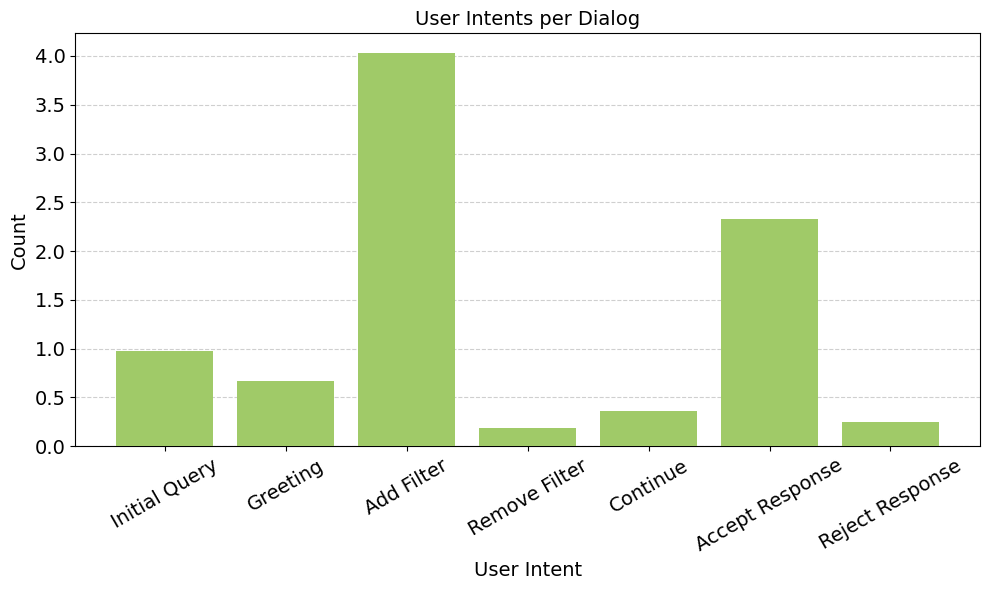

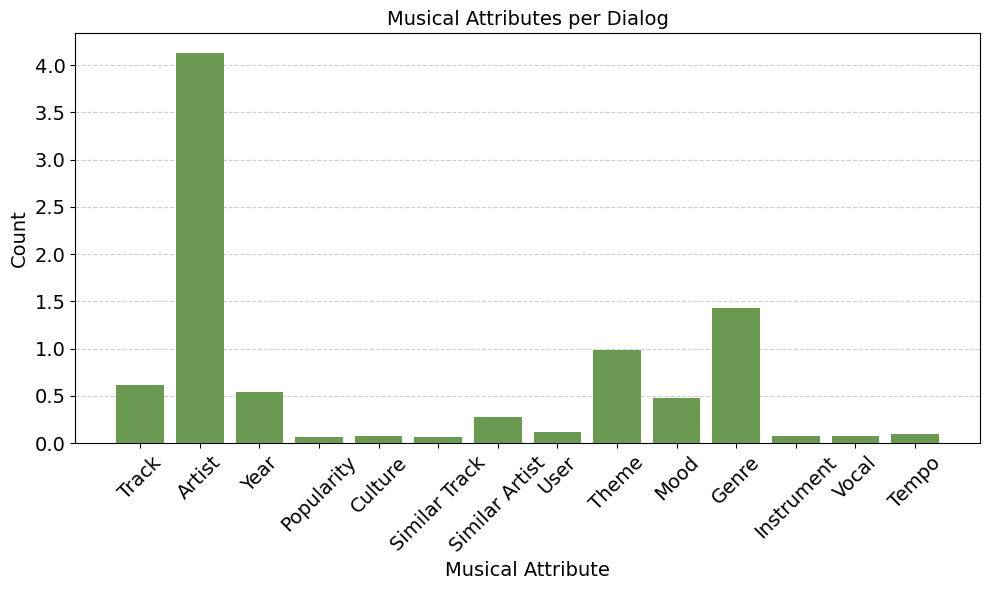

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the data
intent_1_data = {
    'Intent': ['Initial Query', 'Greeting', 'Add Filter', 'Remove Filter', 'Continue', 'Accept Response', 'Reject Response'],
    'Avg Count per Dialog': [0.98, 0.67, 4.03, 0.19, 0.36, 2.33, 0.25]
}

music_attribute_data = {
    'Music Attribute': ['Track', 'Artist', 'Year', 'Popularity', 'Culture', 'Similar Track', 'Similar Artist', 'User', 'Theme', 'Mood', 'Genre', 'Instrument', 'Vocal', 'Tempo'],
    'Avg Count per Dialog': [0.61, 4.13, 0.54, 0.06, 0.07, 0.06, 0.28, 0.12, 0.99, 0.48, 1.43, 0.08, 0.08, 0.10]
}

# Create dataframes
df_intent_1 = pd.DataFrame(intent_1_data)
df_music_attribute = pd.DataFrame(music_attribute_data)

# First plot for User Intent
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(df_intent_1['Intent'], df_intent_1['Avg Count per Dialog'], color='#A0CA68', zorder=3)
ax1.set_title('User Intents per Dialog', fontsize=14)
ax1.set_xlabel('User Intent', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
ax1.tick_params(axis='x', rotation=30, labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)  # Set the grid zorder lower
plt.tight_layout()
plt.show()

# Second plot for Music Attribute
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.bar(df_music_attribute['Music Attribute'], df_music_attribute['Avg Count per Dialog'], color='#6A9951', zorder=3)
ax2.set_title('Musical Attributes per Dialog', fontsize=14)
ax2.set_xlabel('Musical Attribute', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)
ax2.tick_params(axis='x', rotation=45, labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)  # Set the grid zorder lower
plt.tight_layout()
plt.show()
